In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import ensemble #ансамбли
from sklearn import tree

plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

### Предсказать совершение покупки пользователем во время его сессии на сайте некоторого интернет-магазина.

### Необходимо предсказать целевую переменную Revenue — признак покупки. Целевой признак является бинарным категориальным, то есть мы решаем задачу бинарной классификации.

In [2]:
shoppers_data = pd.read_csv('data/online_shoppers_intention.csv')
shoppers_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
# Посмотрим на размер таблицы:
print(shoppers_data.shape)

# В нашей таблице содержится информация о более чем 12 тысячах сессий на сайте интернет-магазина. Каждая сессия описывается 18 признаками.

(12330, 18)


In [4]:
# Заранее удостоверимся в отсутствии пропусков:
shoppers_data.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [5]:
# Теперь закодируем категориальные признаки с помощью простого горячего кодирования, используя уже знакомую нам функцию get_dummies():
dummy_data = pd.get_dummies(shoppers_data)
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


Sessions without purchase : 84.53%
Sessions with purchase: 15.47%


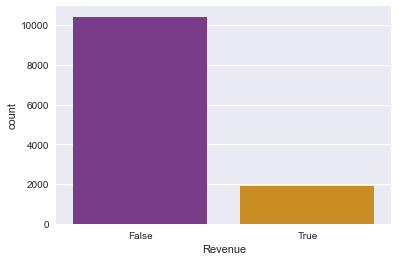

In [6]:
# посмотрим на соотношение классов в данных:
sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
class_percent = dummy_data['Revenue'].value_counts(normalize=True) * 100
print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
print('Sessions with purchase: {:.2f}%'.format(class_percent[1]))

#### Условимся, что лучшей будет считаться та модель, у которой значение метрики F1 для пользователей, совершивших покупку, будет наибольшим.

In [7]:
X, y = dummy_data.drop('Revenue', axis=1), dummy_data['Revenue']

Заранее определимся, как будем производить контроль качества моделей:

* Разделим выборку на тренировочную и тестовую.
* Будем проводить кросс-валидацию на тренировочной выборке (то есть будем делить её на тренировочные и валидационные фолды и считать среднее значение метрики по фолдам).

Будем использовать три показателя:

* значение метрики на тренировочных и валидационных фолдах кросс-валидации (по ним мы будем отслеживать переобучение модели и подбирать внешние параметры);
* значение метрики на отложенной тестовой выборке (оно будет нашим контрольным показателем).
* Другими словами, мы будем сочетать hold-оut- и k-fold-подходы к валидации.

In [8]:
#разбиваем исходную выборку на тренировочную и тестовую в соотношении 80/20
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print('Train:\n', y_train.value_counts(normalize=False), sep='')
print('Test:\n', y_test.value_counts(normalize=False), sep='')

print('Train:\n', y_train.value_counts().sum(), sep='')
print('Test:\n', y_test.value_counts().sum(), sep='')


Train:
False    8367
True     1497
Name: Revenue, dtype: int64
Test:
False    2055
True      411
Name: Revenue, dtype: int64
Train:
9864
Test:
2466


### Задание 6.3

Создайте модель случайного леса. В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

Оцените качество такой модели с помощью кросс-валидации по пяти фолдам. Так как классы несбалансированы, используйте кросс-валидатор StratifiedKFold (перемешивать выборку не нужно).

Для проведения кросс-валидации используйте функцию cross_validate(). Набор данных (параметры X, y) — тренировочная выборка (X_train, y_train). Метрика — -score.

Чему равно среднее значение метрики  на тренировочных и валидационных фолдах? Ответ округлите до двух знаков после точки-разделителя.

In [10]:
# Создаём модель
model_ravenue = ensemble.RandomForestClassifier(
    # criterion='entropy', #критерий информативности
    # max_depth=7, #максимальная глубина
    # min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
# Обучаем модель 
model_ravenue.fit(X_train, y_train)

# Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics = model_selection.cross_validate(
    estimator=model_ravenue, # модель
    X=X, # матрица наблюдений X
    y=y, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика,
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

display(cv_metrics)

{'fit_time': array([1.08158374, 1.06635356, 1.03313112, 1.03400302, 1.02168369]),
 'score_time': array([0.05100393, 0.04951811, 0.05354214, 0.05724931, 0.05603766]),
 'test_score': array([0.68497577, 0.66666667, 0.63714286, 0.56676558, 0.58171745]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [11]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.63


### Задание 6.5

Попробуем использовать несколько вариаций случайного леса и с помощью кривых обучения постараемся выбрать наилучшую из них.

Создайте список из трёх следующих моделей:

Случайный лес из деревьев максимальной глубины 5.
Случайный лес из деревьев максимальной глубины 7.
Случайный лес из деревьев максимальной глубины 12.
Для всех трёх моделей количество деревьев в лесу (n_estimators) возьмите равным 200, количество объектов в листе (min_samples_leaf) — 5. Параметр random_state = 42. Остальные параметры оставьте по умолчанию.

Постройте для каждой из моделей кривую обучения.

In [12]:
# Создаём модель
model_ravenue_5 = ensemble.RandomForestClassifier(
    # criterion='entropy', #критерий информативности
    n_estimators=200,
    max_depth=5, # максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
# Обучаем модель 
model_ravenue_5.fit(X_train, y_train)

# Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics_5 = model_selection.cross_validate(
    estimator=model_ravenue_5, # модель
    X=X, # матрица наблюдений X
    y=y, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика,
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

display(cv_metrics_5)

{'fit_time': array([1.05433726, 1.06376648, 1.05189157, 1.05008125, 1.08441234]),
 'score_time': array([0.06297207, 0.06360316, 0.06396651, 0.06397963, 0.06597853]),
 'test_score': array([0.42253521, 0.52059925, 0.53873239, 0.39922481, 0.51048951]),
 'train_score': array([0.51746324, 0.53064959, 0.53846154, 0.54669704, 0.54778235])}

In [13]:
# Создаём модель
model_ravenue_7 = ensemble.RandomForestClassifier(
    # criterion='entropy', #критерий информативности
    n_estimators=200,
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
# Обучаем модель 
model_ravenue_7.fit(X_train, y_train)

# Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics_7 = model_selection.cross_validate(
    estimator=model_ravenue_7, # модель
    X=X, # матрица наблюдений X
    y=y, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика,
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

In [14]:
# Создаём модель
model_ravenue_12 = ensemble.RandomForestClassifier(
    # criterion='entropy', #критерий информативности
    n_estimators=200,
    max_depth=12, # максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
# Обучаем модель 
model_ravenue_12.fit(X_train, y_train)

# Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics_12 = model_selection.cross_validate(
    estimator=model_ravenue_12, # модель
    X=X, # матрица наблюдений X
    y=y, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика,
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

In [15]:
print('Глубина леса 5')
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics_5['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics_5['test_score'])))
print('__________________________________________________________________________')
print('Глубина леса 7')
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics_7['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics_7['test_score'])))
print('__________________________________________________________________________')
print('Глубина леса 12')
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics_12['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics_12['test_score'])))

Глубина леса 5
Train k-fold mean f1: 0.54
Valid k-fold mean f1: 0.48
__________________________________________________________________________
Глубина леса 7
Train k-fold mean f1: 0.68
Valid k-fold mean f1: 0.60
__________________________________________________________________________
Глубина леса 12
Train k-fold mean f1: 0.78
Valid k-fold mean f1: 0.62


In [16]:
model = ensemble.RandomForestClassifier(
    n_estimators=200, 
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)

model.fit(X_train, y_train)
y_test_predict = model.predict(X_test)
print(metrics.classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

       False       0.90      0.98      0.94      2055
        True       0.81      0.45      0.58       411

    accuracy                           0.89      2466
   macro avg       0.85      0.72      0.76      2466
weighted avg       0.88      0.89      0.88      2466

